In [1]:
#import packages
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as pn
import statistics as st
pn.options.figure_size = (4,3)

In [2]:
# loading data and calculating shape of dfs

adata = sc.read_h5ad("../../clean_myeloid.h5ad")

cell_gene_matrix = adata.X

cell_scores = pd.read_csv("../../milo_cell_scores.csv", index_col = False, header = None)

gene_loadings = pd.read_csv("../../milo_gene_loadings.csv", index_col = False, header = None).T

n_cells, n_factors = cell_scores.shape
n_genes, _ = gene_loadings.shape

In [3]:
# calculating cutoffs (using 3 * mean to reduce the number of genes for highly-loaded factors)

loading_cutoffs = [0] * n_factors
for curr_factor in range(n_factors):
    curr_loadings = gene_loadings[curr_factor]
    loading_cutoffs[curr_factor] = 3 * st.mean(curr_loadings) + 1.5 * st.stdev(curr_loadings)

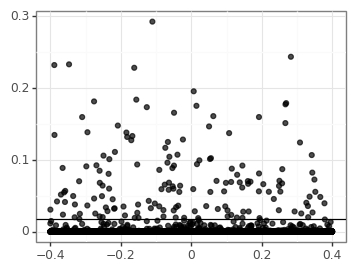

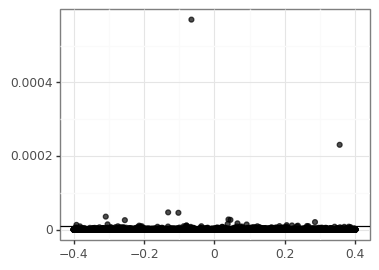

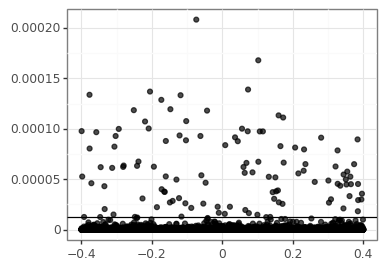

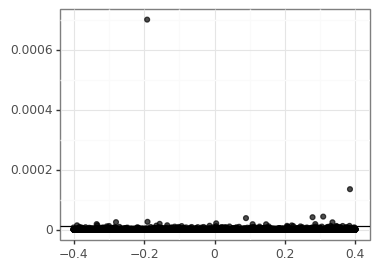

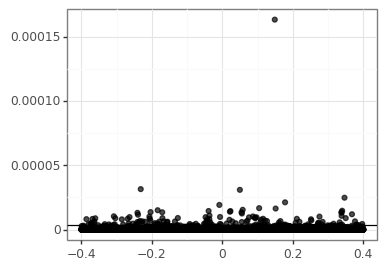

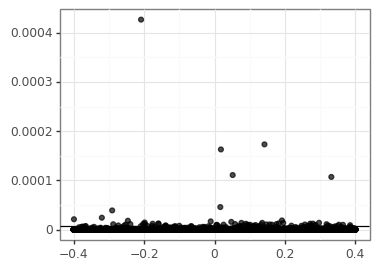

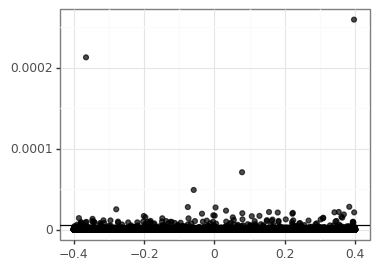

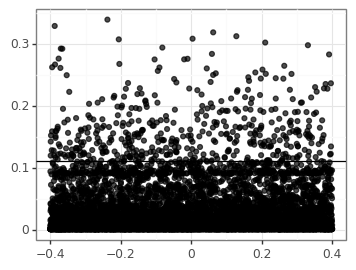

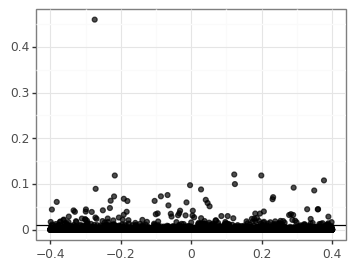

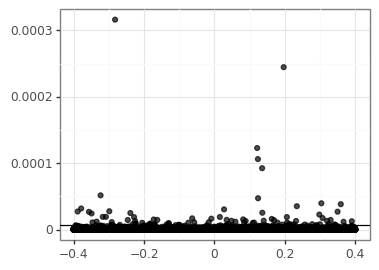

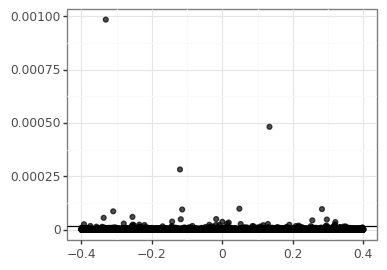

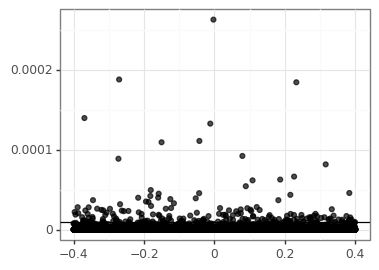

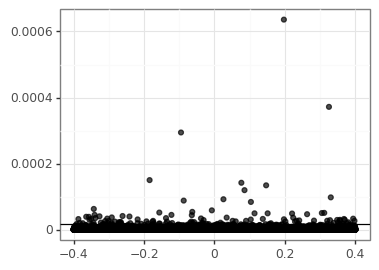

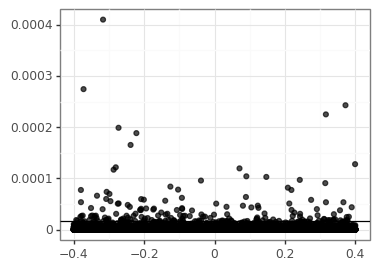

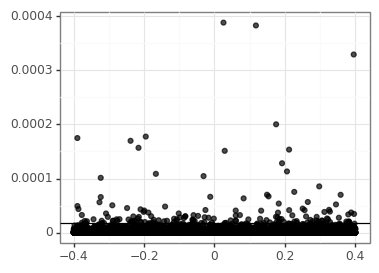

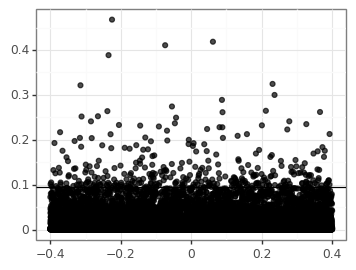

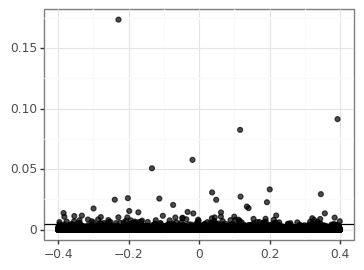

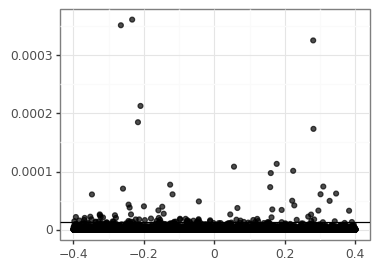

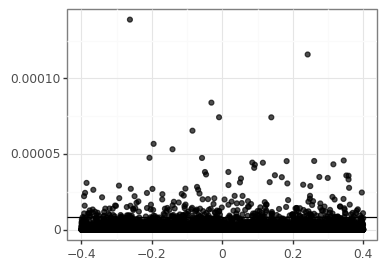

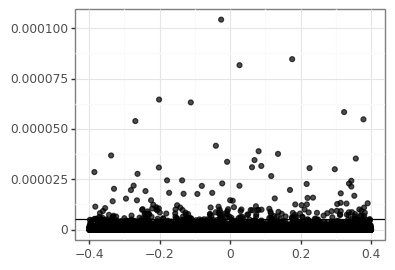

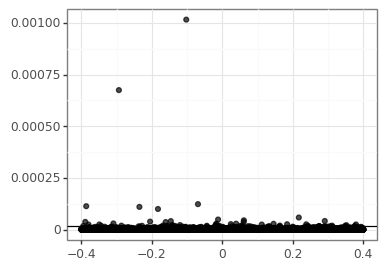

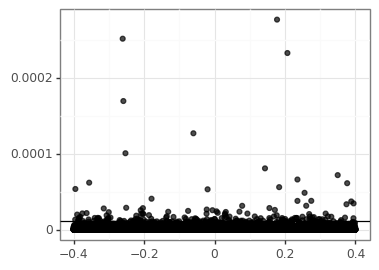

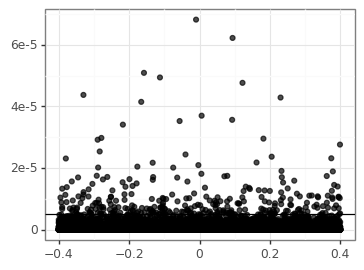

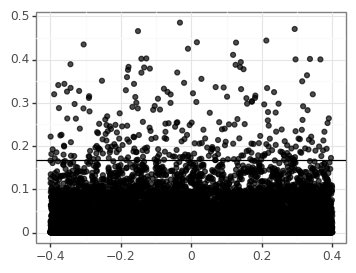

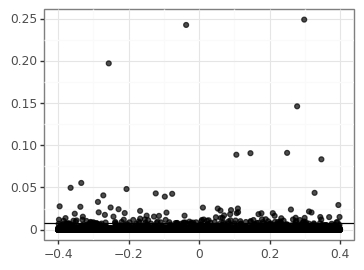

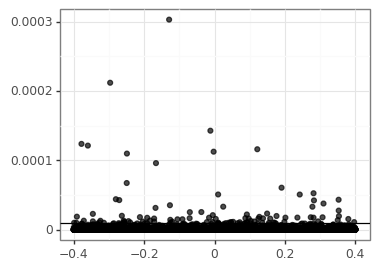

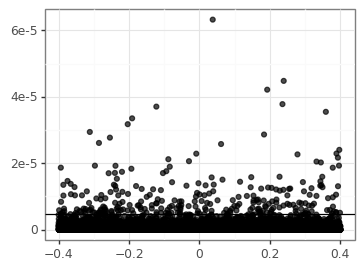

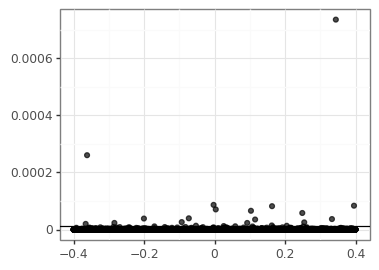

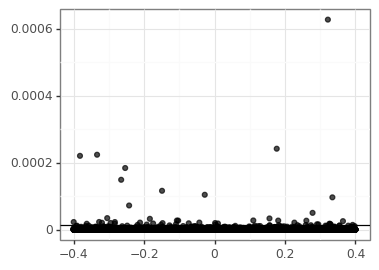

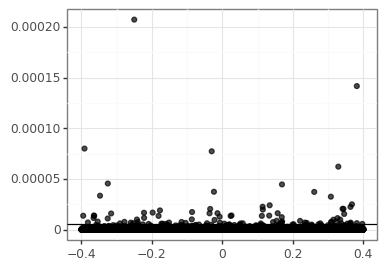

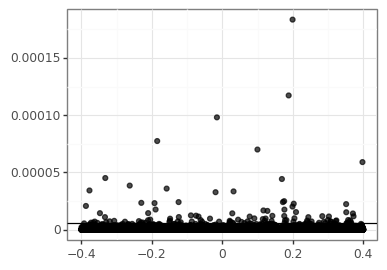

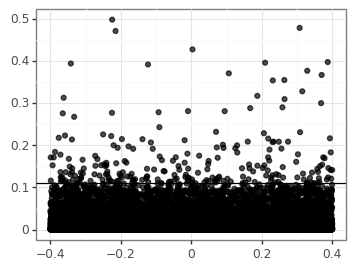

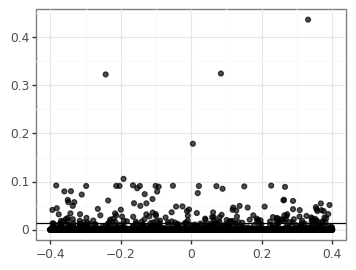

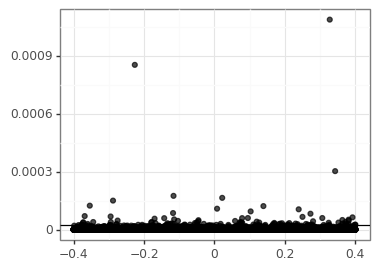

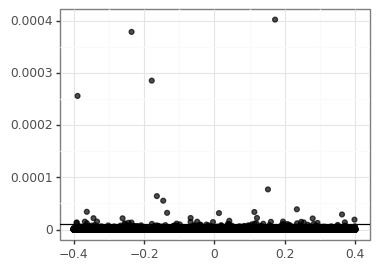

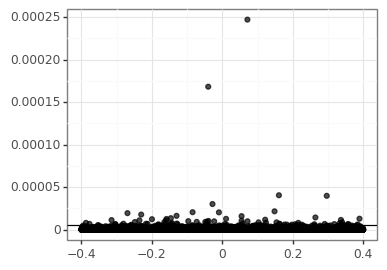

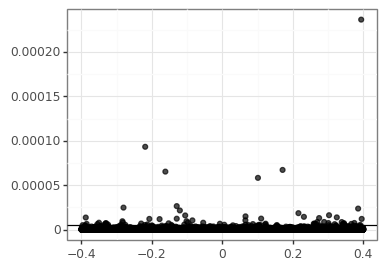

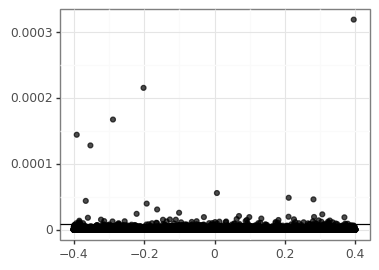

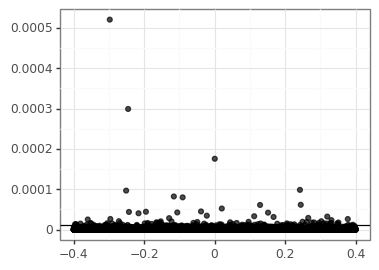

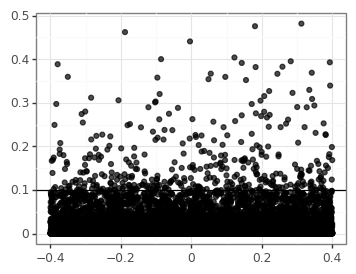

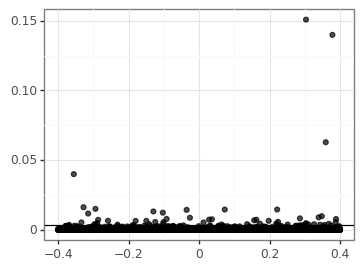

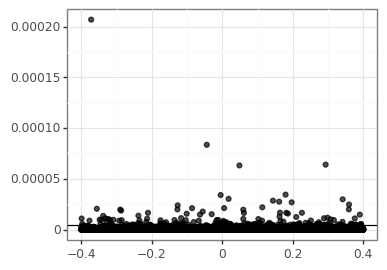

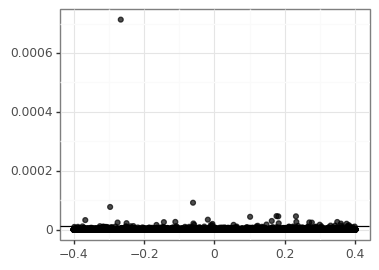

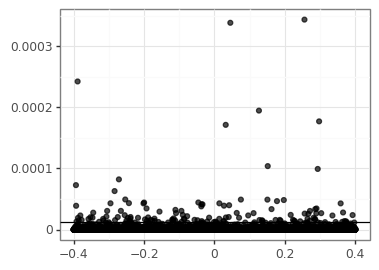

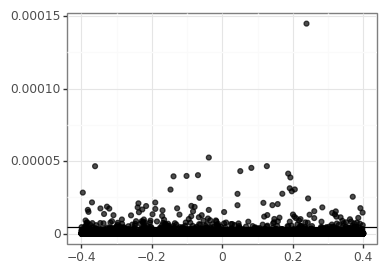

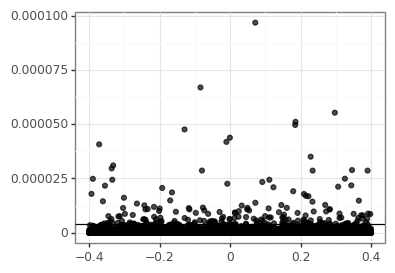

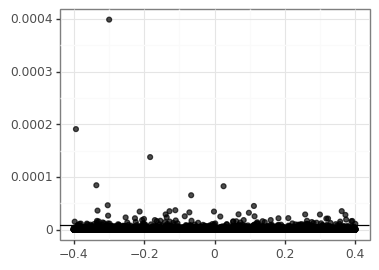

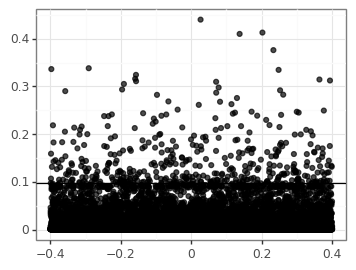

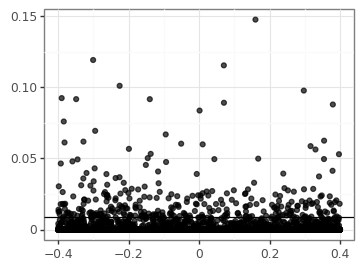

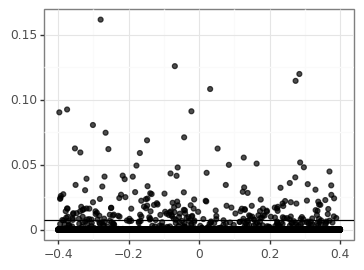

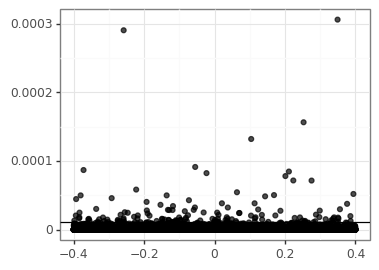

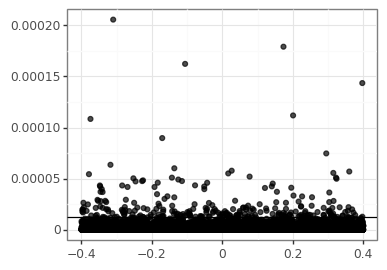

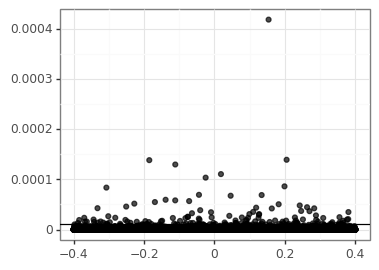

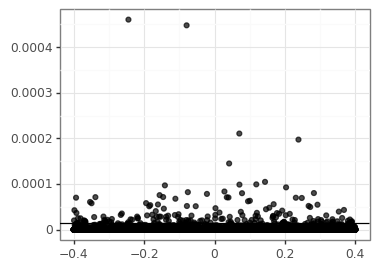

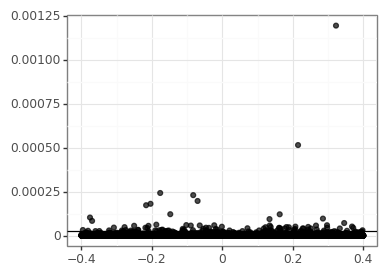

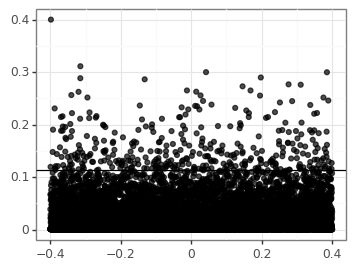

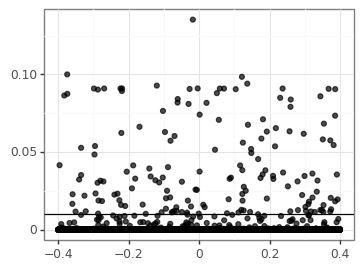

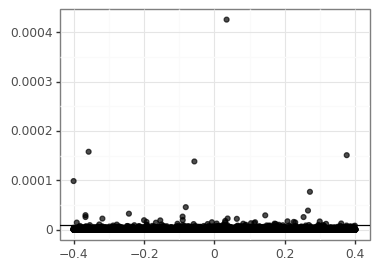

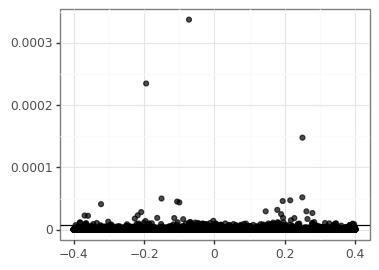

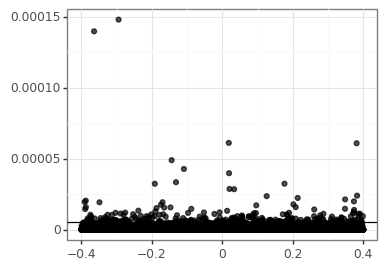

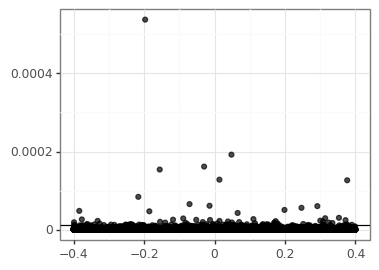

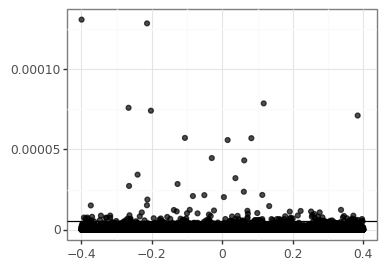

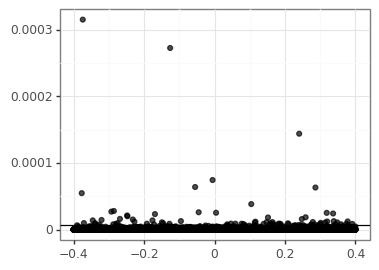

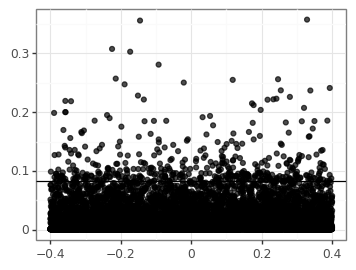

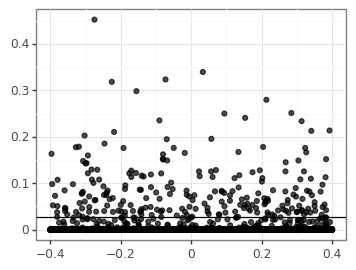

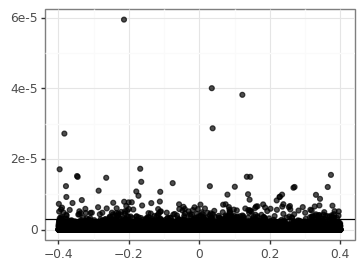

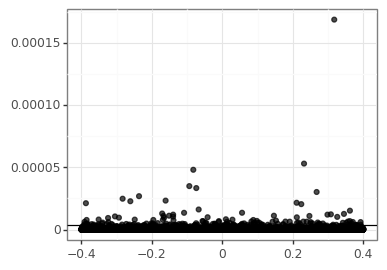

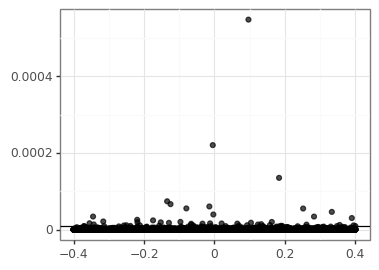

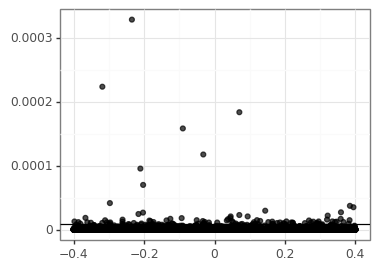

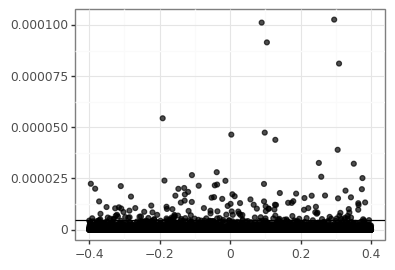

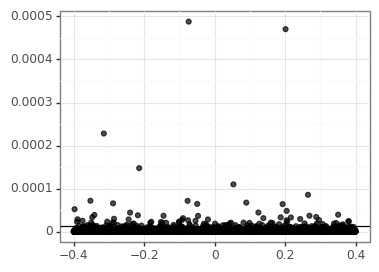

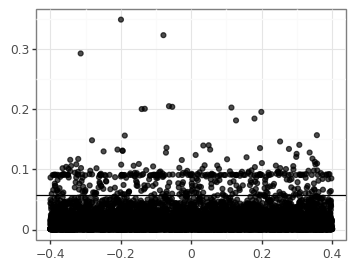

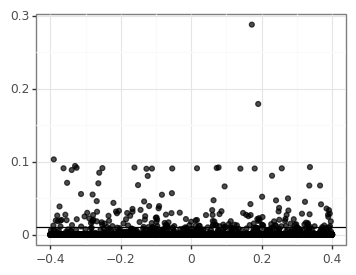

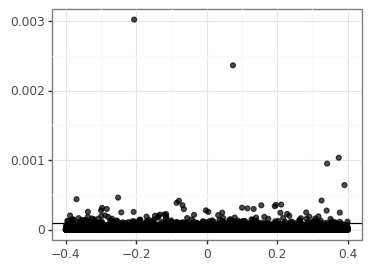

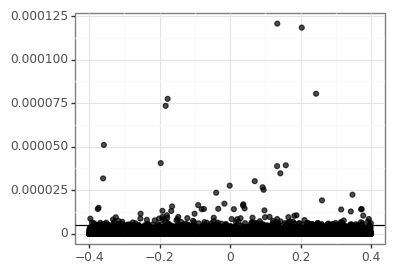

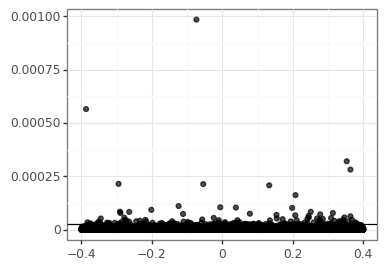

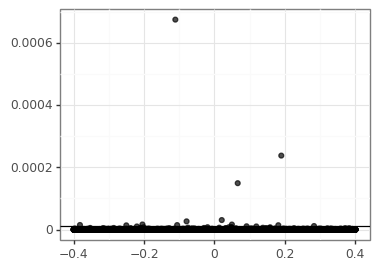

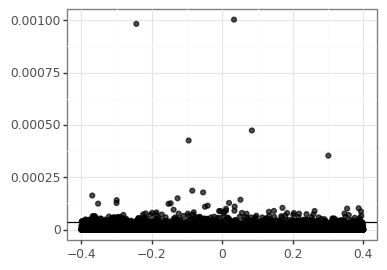

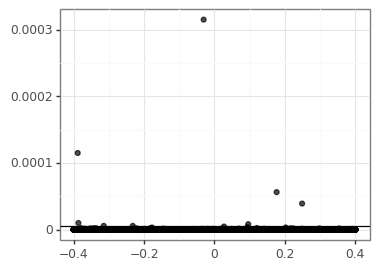

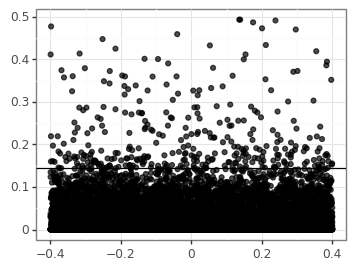

In [4]:
# plotting

for curr_factor in range(n_factors):
    print(pn.ggplot(gene_loadings, pn.aes(x = 0, y = gene_loadings.loc[:,curr_factor]))
     + pn.geom_jitter(alpha = 0.7)
     + pn.geom_abline(pn.aes(intercept = loading_cutoffs[curr_factor], slope = 0))
     + pn.theme_bw()
     + pn.xlab("")
     + pn.ylab(f""))

In [5]:
# collect important genes

# maps factor index to gene indices
top_genes = {}

for curr_factor in range(n_factors):

    gene_indices = []

    for curr_gene in range(n_genes):
        if gene_loadings.iloc[curr_gene, curr_factor] > loading_cutoffs[curr_factor]:
            gene_indices.append(curr_gene)

    top_genes[curr_factor] = gene_indices

In [6]:
# gut check - how many genes per factor?

n_top_genes = [0] * n_factors

for factor, genes in top_genes.items():
    n_top_genes[factor] = len(genes)

In [7]:
# calculating variance for each gene in X

gene_variance = [st.variance(cell_gene_matrix[:, x]) for x in range(n_genes)]

total_variance = sum(gene_variance)

In [8]:
# calculate average expression for each gene in X
gene_expression = [st.mean(cell_gene_matrix[:, x]) for x in range(n_genes)]

In [9]:
# try to rank factors

explained_var = [0] * n_factors
mean_gene_expr = [0] * n_factors

for curr_factor in range(n_factors):
    explained_var[curr_factor] = sum([gene_variance[curr_gene] for curr_gene in top_genes[curr_factor]]) / total_variance
    mean_gene_expr[curr_factor] = st.mean([gene_expression[curr_gene] for curr_gene in top_genes[curr_factor]])

factor_scores = pd.DataFrame({'factor' : list(range(n_factors)), 'explained_variance' : explained_var, 'mean_gene_expression' : mean_gene_expr})

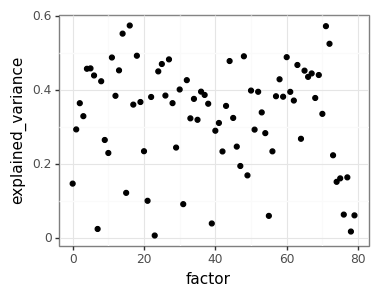

<ggplot: (137273544089)>

In [10]:
(pn.ggplot(factor_scores)
 + pn.aes(x = 'factor', y = 'explained_variance')
 + pn.geom_point()
 + pn.theme_bw())

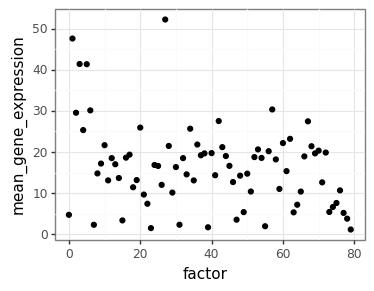

<ggplot: (87215009147)>

In [50]:
(pn.ggplot(factor_scores)
 + pn.aes(x = 'factor', y = 'mean_gene_expression')
 + pn.geom_point()
 + pn.theme_bw())

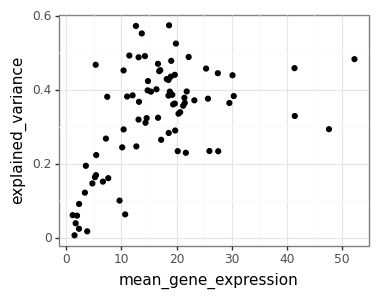

<ggplot: (87215298095)>

In [51]:
(pn.ggplot(factor_scores)
 + pn.aes(x = 'mean_gene_expression', y = 'explained_variance')
 + pn.geom_point()
 + pn.theme_bw())

Layers with keys: norm_count, norm_log